# Shift Approach

In [1]:
!pip install vaderSentiment
!pip install textblob
!pip install scikit-plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [30]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

path = kagglehub.dataset_download("aaron7sun/stocknews")
dataset_path = "/root/.cache/kagglehub/datasets/aaron7sun/stocknews/versions/2"
files = os.listdir(dataset_path)
print(files)

file_path = f"{dataset_path}/Combined_News_DJIA.csv"
data = pd.read_csv(file_path)
upload_DJIA_table = pd.read_csv(f"{dataset_path}/upload_DJIA_table.csv")
RedditNews = pd.read_csv(f"{dataset_path}/RedditNews.csv")
merge = data.merge(upload_DJIA_table,how="inner",on="Date")

['Combined_News_DJIA.csv', 'RedditNews.csv', 'upload_DJIA_table.csv']


In [31]:
# Combine all news headlines in a row
headline = []
for row in range(0, len(merge.index)):
    # Combine all columns from 2 to 27 into a single string
    headline.append(" ".join(str(x) for x in merge.iloc[row, 2:27]))

# Clean the headlines
clean_headline = []
for i in range(0, len(headline)):
    clean_text = re.sub(r"b[(')]", "", headline[i])  # Remove b'
    clean_text = re.sub(r'b[(")]', "", clean_text)  # Remove b"
    clean_text = re.sub(r"\'", "", clean_text)  # Remove \'
    clean_text = re.sub(r"http\S+|www\S+|https\S+", "", clean_text, flags=re.MULTILINE)  # Remove URLs
    clean_text = re.sub(r"[^a-zA-Z\s]", "", clean_text)  # Remove special characters, punctuation, numbers
    clean_text = clean_text.lower()  # Convert to lowercase
    clean_text = re.sub(r"\s+", " ", clean_text).strip()  # Remove extra whitespaces
    clean_headline.append(clean_text)

# Add the cleaned headlines as a new column in the original dataframe
merge['Combined_News'] = clean_headline

In [32]:
# Get Subjectivity and polarity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

merge['Subjectivity'] = merge['Combined_News'].apply(get_subjectivity)
merge['Polarity'] = merge['Combined_News'].apply(get_polarity)

sia = SentimentIntensityAnalyzer()

# Define the function to get sentiment scores
def getSIA(text):
    return sia.polarity_scores(text)

# Apply sentiment analysis and extract scores
sentiments = merge['Combined_News'].apply(getSIA)
merge['compound'] = sentiments.apply(lambda x: x['compound'])
merge['neg'] = sentiments.apply(lambda x: x['neg'])
merge['pos'] = sentiments.apply(lambda x: x['pos'])
merge['neu'] = sentiments.apply(lambda x: x['neu'])

In [6]:
relevant_features = merge[['Date','Label']]

# Shift relevant features like sentiment scores to align with the previous day's data.
relevant_features['Prev_Daily_Sentiment'] = merge['compound'].shift(1)
relevant_features['Prev_Close'] = merge['Close'].shift(1)
relevant_features['Prev_Label'] = merge['Label'].shift(1)
relevant_features['Prev_Open'] = merge['Open'].shift(1)
relevant_features['Prev_High'] = merge['High'].shift(1)
relevant_features['Prev_Low'] = merge['Low'].shift(1)
relevant_features['Prev_Volume'] = merge['Volume'].shift(1)
relevant_features['Prev_Subjectivity'] = merge['Subjectivity'].shift(1)
relevant_features['Prev_Polarity'] = merge['Polarity'].shift(1)

relevant_features.dropna(inplace=True)
relevant_features

<ipython-input-6-ec284cea5868>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_features['Prev_Daily_Sentiment'] = merge['compound'].shift(1)
<ipython-input-6-ec284cea5868>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_features['Prev_Close'] = merge['Close'].shift(1)
<ipython-input-6-ec284cea5868>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,Date,Label,Prev_Daily_Sentiment,Prev_Close,Prev_Label,Prev_Open,Prev_High,Prev_Low,Prev_Volume,Prev_Subjectivity,Prev_Polarity
1,2008-08-11,1,-0.9982,11734.320312,0.0,11432.089844,11759.959961,11388.040039,212830000.0,0.267549,-0.048568
2,2008-08-12,0,-0.9838,11782.349609,1.0,11729.669922,11867.110352,11675.530273,183190000.0,0.374806,0.109325
3,2008-08-13,0,-0.9679,11642.469727,0.0,11781.700195,11782.349609,11601.519531,173590000.0,0.536234,-0.044302
4,2008-08-14,1,-0.9792,11532.959961,0.0,11632.809570,11633.780273,11453.339844,182550000.0,0.364021,0.005842
5,2008-08-15,1,-0.9876,11615.929688,1.0,11532.070312,11718.280273,11450.889648,159790000.0,0.375099,0.035469
...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0,-0.8619,17400.750000,0.0,17946.630859,17946.630859,17356.339844,239000000.0,0.375510,0.037381
1985,2016-06-28,1,-0.9644,17140.240234,0.0,17355.210938,17355.210938,17063.080078,138740000.0,0.352311,-0.014015
1986,2016-06-29,1,-0.9571,17409.720703,1.0,17190.509766,17409.720703,17190.509766,112190000.0,0.352649,0.046560
1987,2016-06-30,1,-0.9975,17694.679688,1.0,17456.019531,17704.509766,17456.019531,106380000.0,0.389617,0.052622


In [11]:
relevant_features['Date'] = pd.to_datetime(relevant_features['Date'])
train_data = relevant_features[relevant_features['Date'] < '2016-01-01']
test_data = relevant_features[relevant_features['Date'] >= '2016-01-01']

X_train = train_data.drop(['Label','Date'], axis=1)
y_train = train_data['Label']
X_test = test_data.drop(['Label','Date'], axis=1)
y_test = test_data['Label']

              precision    recall  f1-score   support

           0       0.65      0.20      0.30        56
           1       0.59      0.91      0.72        70

    accuracy                           0.60       126
   macro avg       0.62      0.56      0.51       126
weighted avg       0.61      0.60      0.53       126

Accuracy: 0.5952


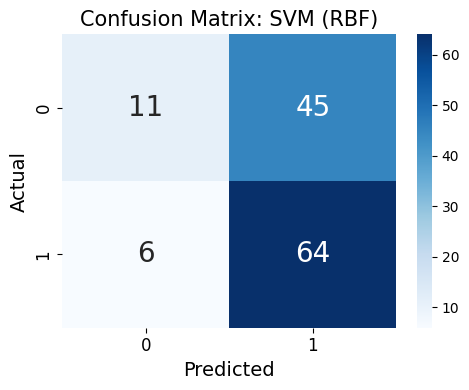

In [15]:
# SVM
from sklearn.svm import SVC
model_svm1 = SVC(kernel='rbf', class_weight='balanced', C=0.4, probability=True)
model_svm1.fit(X_train, y_train)
y_pred_svm1 = model_svm1.predict(X_test)

print(classification_report(y_test, y_pred_svm1))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm1):.4f}")

cm_svm_rbf = confusion_matrix(y_test, y_pred_svm1)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm_rbf, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 20})  # Increase annot_kws size for larger font
plt.title("Confusion Matrix: SVM (RBF)", fontsize=15)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('cm_svm.png')
plt.show()

              precision    recall  f1-score   support

           0       0.39      0.32      0.35        56
           1       0.53      0.60      0.56        70

    accuracy                           0.48       126
   macro avg       0.46      0.46      0.46       126
weighted avg       0.47      0.48      0.47       126

Accuracy: 0.4762


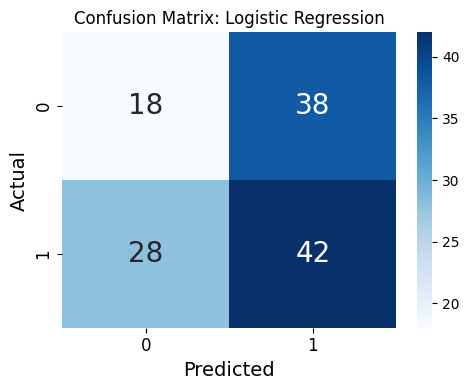

In [12]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model_logit1 = LogisticRegression(class_weight='balanced')
model_logit1.fit(X_train, y_train)
y_pred_logit1 = model_logit1.predict(X_test)

print(classification_report(y_test, y_pred_logit1))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logit1):.4f}")

cm_logit = confusion_matrix(y_test, y_pred_logit1)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_logit, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 20})  # Increase annot_kws size for larger font
plt.title("Confusion Matrix: Logistic Regression", fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('cm_logit.png')
plt.show()

              precision    recall  f1-score   support

           0       0.44      0.66      0.53        56
           1       0.55      0.33      0.41        70

    accuracy                           0.48       126
   macro avg       0.49      0.49      0.47       126
weighted avg       0.50      0.48      0.46       126

Accuracy: 0.4762


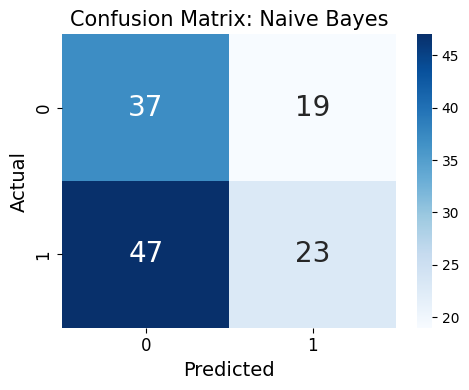

In [18]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
model_nb1 = GaussianNB(priors=[0.5, 0.5])
model_nb1.fit(X_train, y_train)
y_pred_nb1 = model_nb1.predict(X_test)
print(classification_report(y_test, y_pred_nb1))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb1):.4f}")

cm_nb = confusion_matrix(y_test, y_pred_nb1)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 20})
plt.title("Confusion Matrix: Naive Bayes", fontsize=15)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('cm_nb.png')
plt.show()

              precision    recall  f1-score   support

           0       0.45      0.43      0.44        56
           1       0.56      0.59      0.57        70

    accuracy                           0.52       126
   macro avg       0.51      0.51      0.51       126
weighted avg       0.51      0.52      0.51       126

Accuracy: 0.5159


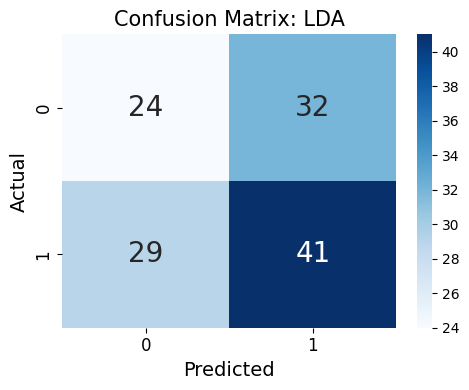

In [20]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_lda1 = LinearDiscriminantAnalysis()
model_lda1.fit(X_train, y_train)
y_pred_lda1 = model_lda1.predict(X_test)
print(classification_report(y_test, y_pred_lda1))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lda1):.4f}")

cm_lda = confusion_matrix(y_test, y_pred_lda1)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 20})
plt.title("Confusion Matrix: LDA", fontsize=15)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('cm_lda.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=1000. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=17, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.1s
[CV] END max_depth=17, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.2s
[CV] END max_depth=17, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.1s
[CV] END max_depth=17, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.1s
[CV] END max_depth=17, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.1s
              precision    recall  f1-score   support

           0       0.58      0.55      0.57        56
           1       0.66      0.69      0.67        70

    accuracy                           0.63       126
   macro avg       0.62      0.62      0.62       126
weighted avg       0.63      0.63      0.63       126

Accuracy: 0.6270


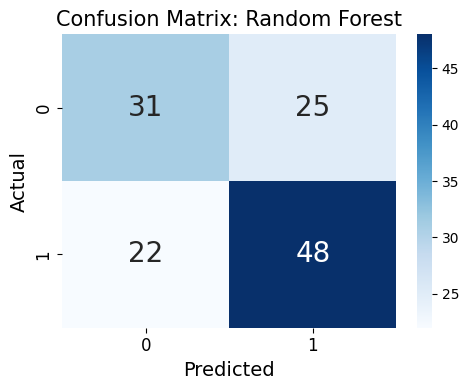

In [23]:
# Best RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_distributions = {
    'n_estimators': [10],
    'max_depth': [17],
    'min_samples_split': [3],
    'min_samples_leaf': [1],
    'max_features': ['log2']
}

# Randomized Tranined with sentimental socre
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                n_iter=1000, cv=5, verbose=2, random_state=42, scoring='accuracy')
rf_random.fit(X_train, y_train)

# Best Random Forest Model
best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 20})
plt.title("Confusion Matrix: Random Forest", fontsize=15)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('cm_rf.png')
plt.show()

In [24]:
y_prob_nb = model_nb1.predict_proba(X_test)[:, 1]
y_prob_lr = model_logit1.predict_proba(X_test)[:, 1]
y_prob_svm = model_svm1.predict_proba(X_test)[:, 1]
y_prob_lda = model_lda1.predict_proba(X_test)[:, 1]
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

In [25]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# NB
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_prob_nb)
auprc_nb = average_precision_score(y_test, y_prob_nb)

# Logit
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
auprc_lr = average_precision_score(y_test, y_prob_lr)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_prob_svm)
auprc_svm = average_precision_score(y_test, y_prob_svm)

# LDA
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)
precision_lda, recall_lda, _ = precision_recall_curve(y_test, y_prob_lda)
auprc_lda = average_precision_score(y_test, y_prob_lda)

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
auprc_rf = average_precision_score(y_test, y_prob_rf)

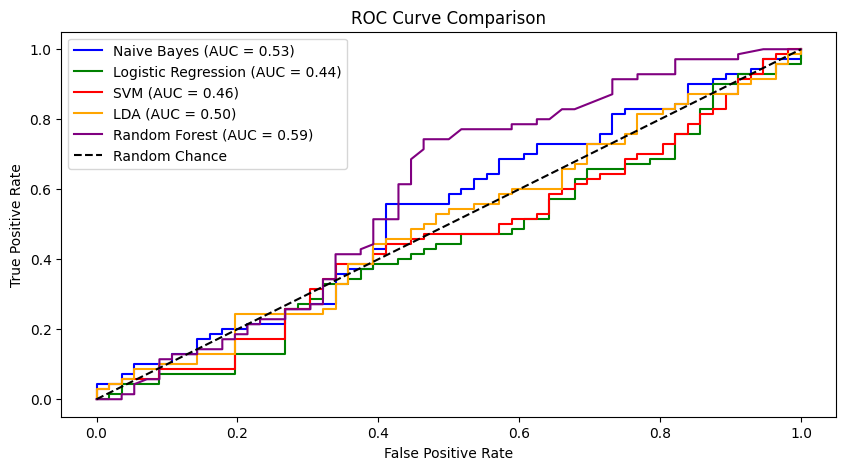

In [26]:
# Plotting the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})', color='blue')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='green')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='red')
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {roc_auc_lda:.2f})', color='orange')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig('ROC Comparison.png')
plt.show()

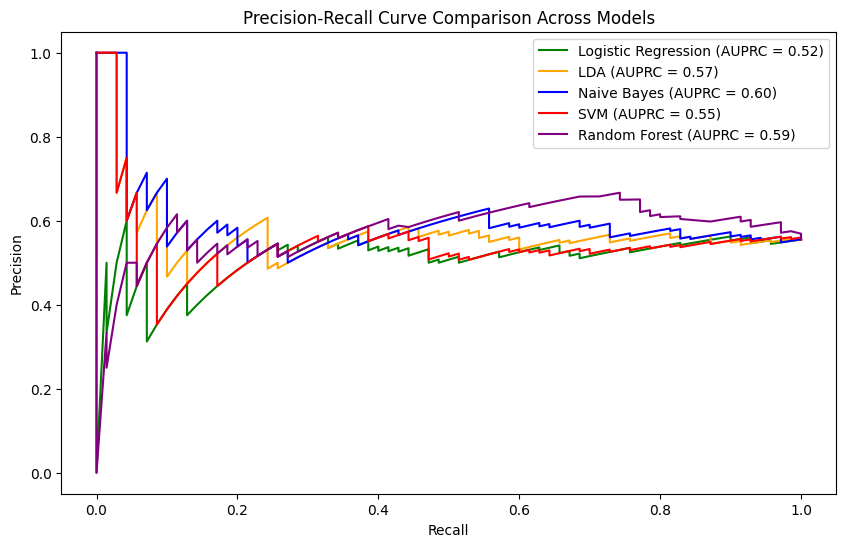

In [27]:
# Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUPRC = {auprc_lr:.2f})', color='green')
plt.plot(recall_lda, precision_lda, label=f'LDA (AUPRC = {auprc_lda:.2f})', color='orange')
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AUPRC = {auprc_nb:.2f})', color='blue')
plt.plot(recall_svm, precision_svm, label=f'SVM (AUPRC = {auprc_svm:.2f})', color='red')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {auprc_rf:.2f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison Across Models')
plt.legend()
plt.savefig('Precision-Recall Curve.png')
plt.show()

# No Shift Approach

In [33]:
# Exclude Close Price
df = merge[['Date','Label','Open','High','Low','Volume','Subjectivity','Polarity','compound','neg','pos','neu']]

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
train_data1 = df[df['Date'] < '2016-01-01']
test_data1 = df[df['Date'] >= '2016-01-01']

X_train1 = train_data1.drop(['Label','Date'], axis=1)
y_train1 = train_data1['Label']
X_test1 = test_data1.drop(['Label','Date'], axis=1)
y_test1 = test_data1['Label']

<ipython-input-36-e1e69e5a19d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [39]:
# SVM
model_svm2 = SVC(kernel='rbf', class_weight='balanced', C=1, probability=True)
model_svm2.fit(X_train1, y_train1)
y_pred_svm2 = model_svm2.predict(X_test1)
print(classification_report(y_test1, y_pred_svm2))

              precision    recall  f1-score   support

           0       0.75      0.05      0.10        56
           1       0.57      0.99      0.72        70

    accuracy                           0.57       126
   macro avg       0.66      0.52      0.41       126
weighted avg       0.65      0.57      0.44       126



In [44]:
# Logistic regression
model_logit2 = LogisticRegression(class_weight='balanced')
model_logit2.fit(X_train1, y_train1)
y_pred_logit2 = model_logit2.predict(X_test1)
print(classification_report(y_test1, y_pred_logit2))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        56
           1       0.92      0.81      0.86        70

    accuracy                           0.86       126
   macro avg       0.86      0.86      0.86       126
weighted avg       0.86      0.86      0.86       126



In [45]:
# NB
model_nb2 = GaussianNB(priors=[0.5, 0.5])
model_nb2.fit(X_train1, y_train1)
y_pred_nb2 = model_nb2.predict(X_test1)
print(classification_report(y_test1, y_pred_nb2))

              precision    recall  f1-score   support

           0       0.75      0.05      0.10        56
           1       0.57      0.99      0.72        70

    accuracy                           0.57       126
   macro avg       0.66      0.52      0.41       126
weighted avg       0.65      0.57      0.44       126



In [40]:
# LDA
model_lda2 = LinearDiscriminantAnalysis()
model_lda2.fit(X_train1, y_train1)
y_pred_lda2 = model_lda2.predict(X_test1)
print(classification_report(y_test1, y_pred_lda2))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        56
           1       0.90      0.86      0.88        70

    accuracy                           0.87       126
   macro avg       0.86      0.87      0.86       126
weighted avg       0.87      0.87      0.87       126



In [43]:
# Random Forest
model_rf2 = RandomForestClassifier(n_estimators=90, random_state=0)
model_rf2.fit(X_train1, y_train1)
y_pred_rf2 = model_rf2.predict(X_test1)
print(classification_report(y_test1, y_pred_rf2))

              precision    recall  f1-score   support

           0       0.65      0.55      0.60        56
           1       0.68      0.76      0.72        70

    accuracy                           0.67       126
   macro avg       0.66      0.66      0.66       126
weighted avg       0.66      0.67      0.66       126



<ipython-input-47-e9c4eda13fc0>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy, ax=ax_bar, palette="magma")


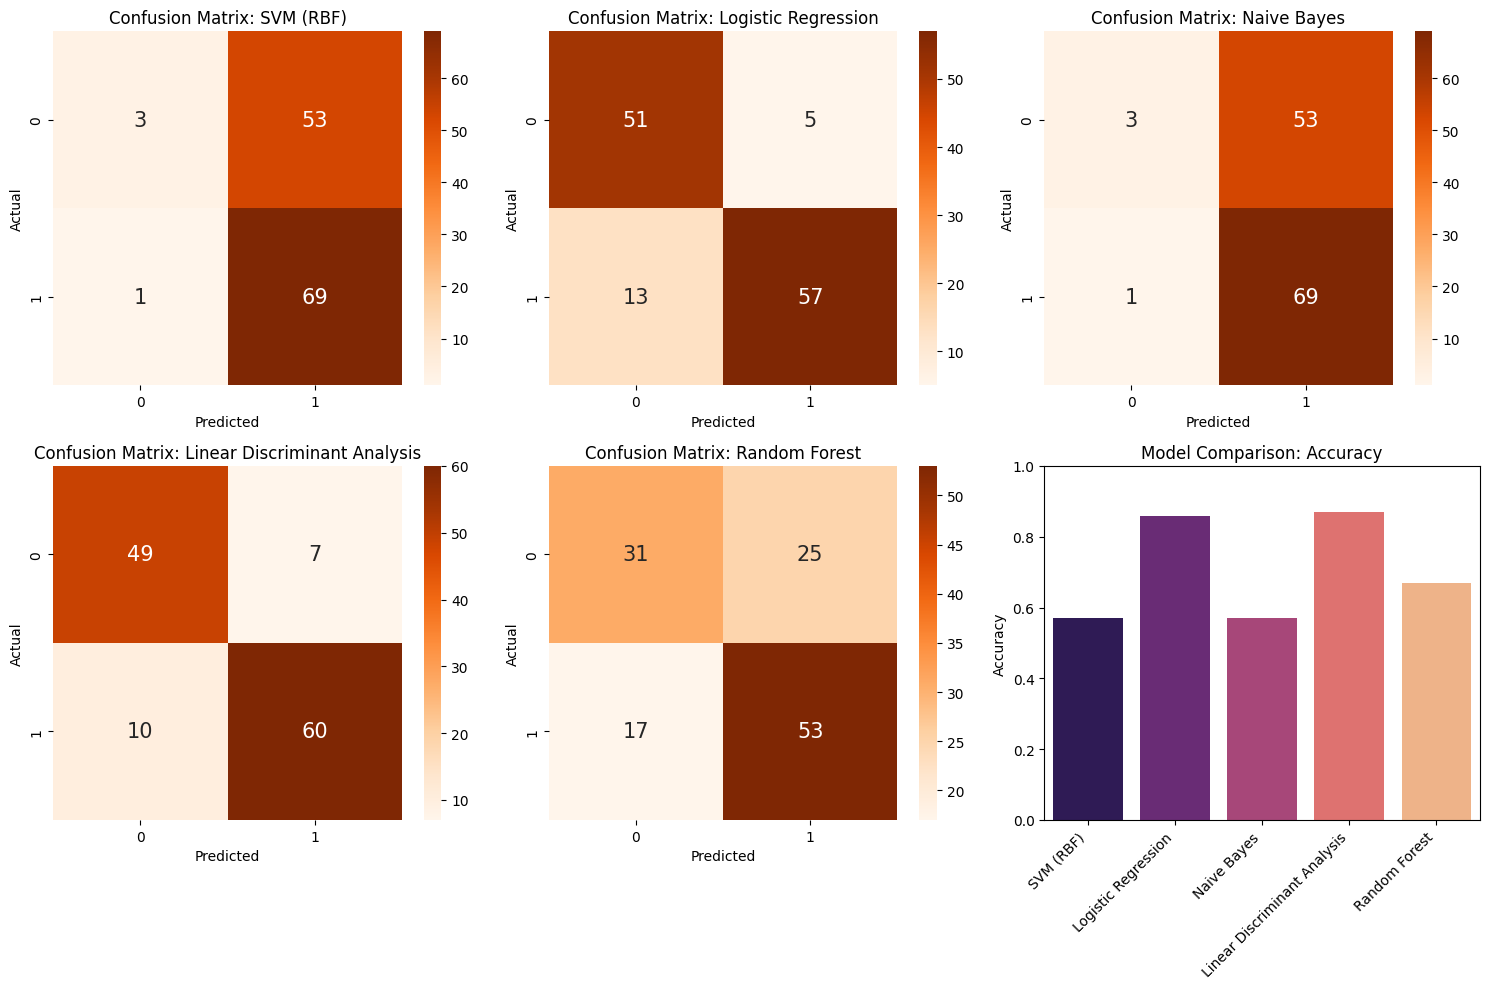

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "SVM (RBF)": model_svm2,
    "Logistic Regression": model_logit2,
    "Naive Bayes": model_nb2,
    "Linear Discriminant Analysis": model_lda2,
    "Random Forest": model_rf2,
}

accuracy = [0.57, 0.86, 0.57, 0.87, 0.67]
model_names = list(models.keys())

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test1)
    cm = confusion_matrix(y_test1, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[i], annot_kws={"size": 15})
    axes[i].set_title(f"Confusion Matrix: {name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

for j in range(len(models), len(axes) - 1):
    fig.delaxes(axes[j])


ax_bar = axes[-1]
x_positions = np.arange(len(model_names))
sns.barplot(x=model_names, y=accuracy, ax=ax_bar, palette="magma")
ax_bar.set_title('Model Comparison: Accuracy')
ax_bar.set_ylabel('Accuracy')
ax_bar.set_ylim(0, 1)
ax_bar.set_xticks(x_positions)
ax_bar.set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('No Shift Confusion Matrices.png')
plt.show()

In [49]:
y_prob_nb2 = model_nb2.predict_proba(X_test1)[:, 1]
y_prob_lr2 = model_logit2.predict_proba(X_test1)[:, 1]
y_prob_svm2 = model_svm2.predict_proba(X_test1)[:, 1]
y_prob_lda2 = model_lda2.predict_proba(X_test1)[:, 1]
y_prob_rf2 = model_rf2.predict_proba(X_test1)[:, 1]

In [50]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# NB
fpr_nb, tpr_nb, _ = roc_curve(y_test1, y_prob_nb2)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, _ = precision_recall_curve(y_test1, y_prob_nb2)
auprc_nb = average_precision_score(y_test1, y_prob_nb2)

# Logit
fpr_lr, tpr_lr, _ = roc_curve(y_test1, y_prob_lr2)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, _ = precision_recall_curve(y_test1, y_prob_lr2)
auprc_lr = average_precision_score(y_test1, y_prob_lr2)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test1, y_prob_svm2)
roc_auc_svm = auc(fpr_svm, tpr_svm)
precision_svm, recall_svm, _ = precision_recall_curve(y_test1, y_prob_svm2)
auprc_svm = average_precision_score(y_test1, y_prob_svm2)

# LDA
fpr_lda, tpr_lda, _ = roc_curve(y_test1, y_prob_lda2)
roc_auc_lda = auc(fpr_lda, tpr_lda)
precision_lda, recall_lda, _ = precision_recall_curve(y_test1, y_prob_lda2)
auprc_lda = average_precision_score(y_test1, y_prob_lda2)

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_test1, y_prob_rf2)
roc_auc_rf = auc(fpr_rf, tpr_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_test1, y_prob_rf2)
auprc_rf = average_precision_score(y_test1, y_prob_rf2)

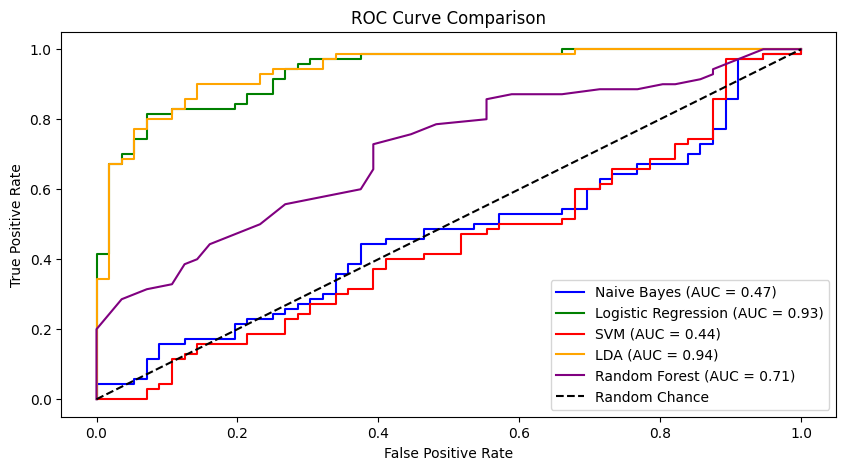

In [51]:
# Plotting the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})', color='blue')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='green')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='red')
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {roc_auc_lda:.2f})', color='orange')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig('ROC Comparison.png')
plt.show()

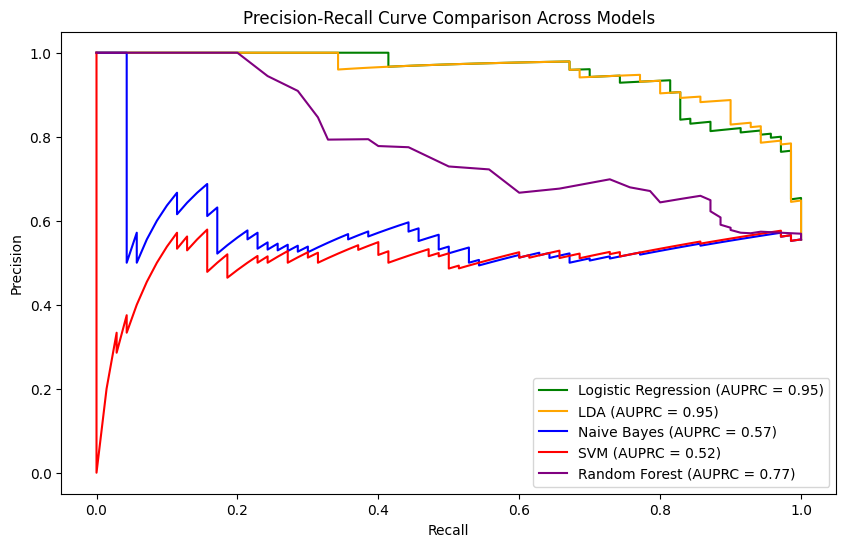

In [52]:
# Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUPRC = {auprc_lr:.2f})', color='green')
plt.plot(recall_lda, precision_lda, label=f'LDA (AUPRC = {auprc_lda:.2f})', color='orange')
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AUPRC = {auprc_nb:.2f})', color='blue')
plt.plot(recall_svm, precision_svm, label=f'SVM (AUPRC = {auprc_svm:.2f})', color='red')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {auprc_rf:.2f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison Across Models')
plt.legend()
plt.savefig('Precision-Recall Curve.png')
plt.show()